In [1]:
from lib.environments import AdvectionEnvironment
from lib.models import AdvectionIRCNN
from lib.models.wrappers import MarlModel
from tianshou.utils.net.common import ActorCritic
from lib.policy.ppo import MarlPPOPolicy
from lib.distributions import ElementwiseNormal

import torch
import math
import numpy as np
from tqdm import tqdm
import os

# Settings for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
FONT_SIZE = 16
plt.rcParams['figure.figsize'] = (4, 4)
# Set global font size
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = 12

In [2]:
# function to plot images side by side 
def plot_n(ims, titles):   
    fig, axes = plt.subplots(1, len(ims), figsize=(6, 2))
    axes[0].imshow(ims[0], cmap='gray', interpolation="none")
    axes[0].axis("off")
    axes[1].imshow(ims[1], vmin=-0.03, vmax=0.03, cmap='gray', interpolation="none")
    axes[1].axis("off")
    axes[2].imshow(ims[2], vmin=-0.03, vmax=0.03, cmap='gray', interpolation="none")
    axes[2].axis("off")

    axes[0].set_title(titles[0])
    axes[1].set_title(titles[1])
    axes[2].set_title(titles[2])
    plt.tight_layout()
    
def calculate_correlation(predictions, ground_truth):
    correlation_coefficient = np.corrcoef(predictions.flatten(), ground_truth.flatten())[0, 1]
    return correlation_coefficient

In [3]:
# Figures will be saved to this path
FIG_PATH = f'results_dump/figures/advection/'

In [4]:
DEVICE = "cuda:0"
backbone = AdvectionIRCNN()
actor = MarlModel(backbone=backbone, _is="actor").to(DEVICE)
critic = MarlModel(backbone=backbone, _is="critic").to(DEVICE)
actor_critic = ActorCritic(actor, critic)

In [5]:
EPOCH = 1499  # load EPOCH=1499 for best model
POLICY_READ_PATH = f'./weights/policy_launch_platform/mnist_train_ppo_IRCNN_eplen:4_seed:0_subsample:4_discount:0.95_growing_ep_len_maxed/policy_ep{EPOCH}.pt'

In [6]:
dist = ElementwiseNormal
ElementwiseNormal.marl = True
policy = MarlPPOPolicy(actor=actor_critic.actor,
             critic=actor_critic.critic,
              dist_fn=dist,
              optim=None,
             ent_coef=0.05)
policy.load_state_dict(torch.load(POLICY_READ_PATH, map_location=torch.device(DEVICE)))
print("Built model")

Built model


In [7]:
env = AdvectionEnvironment(
    ep_len=10,
    train=False,
    img_size=64,
    dataset_name="mnist",  # Possible datasets: mnist or fashion
    velocity_field_type="train" # Possible velocity fields: train, train2, vortex, vortex2...
)

In [8]:
# Function to calculate approximation of perfect action 
def mde_upwind_diffusion_term(states, c_x, c_y, dx, dy, dt):
    # states is in dims (time, x, y)
    mid_idx = states.shape[0] // 2 + 1

    # Compute first time derivative
    du_dt = np.gradient(states, dt, axis=0)

    # Compute second time derivative 
    d2u_dt2 = np.gradient(du_dt, dt, axis=0)

    # Compute third order derivative
    d3u_dt3 = np.gradient(d2u_dt2, dt, axis=0)

    t_dir_error = dt / 2 * d2u_dt2[mid_idx]  

    # Compute first space derivatives
    edge_order=2
    du_dx, du_dy = np.gradient(states, dx, dy, axis=(1, 2), edge_order=edge_order)

    # Compute second and third space derivatives
    d2u_dx2 = np.gradient(du_dx, dx, axis=1, edge_order=edge_order)
    d3u_dx3 = np.gradient(d2u_dx2, dx, axis=1, edge_order=edge_order)
    d2u_dy2 = np.gradient(du_dy, dy, axis=2, edge_order=edge_order)
    d3u_dy3 = np.gradient(d2u_dy2, dy, axis=2, edge_order=edge_order)

    x_dir_error = np.abs(c_x) * dx / 2 * d2u_dx2[mid_idx] 
    y_dir_error = np.abs(c_y) * dy / 2 * d2u_dy2[mid_idx]
               
    # Return diffusion term
    return dt * (t_dir_error + x_dir_error + y_dir_error), mid_idx


In [9]:
def rollout_and_compute_mde_term(env, num_steps=30, do_plot=False):
    states = []
    dns_states = []
    actions = []    
    
    _obs, _ = env.reset()
    for _ in range(num_steps):
        states.append(env.state)
        dns_states.append(env.gt_state)
        act_mean = actor.get_action_mean(_obs).detach().squeeze().cpu().numpy()
        actions.append(act_mean)
        _obs, _, _, _, _ = env.step(np.expand_dims(act_mean, axis=0))
    
    states, dns_states, actions = np.array(states), np.array(dns_states), np.array(actions)
    analyt, mid_idx = mde_upwind_diffusion_term(states, env.c_x, env.c_y, env.dx, env.dy, env.dt)
    coef = calculate_correlation(actions[mid_idx + 1], analyt)

    if do_plot:
        plot_n([states[mid_idx + 1], actions[mid_idx + 1], analyt], titles=["Input", "Action", "Approx. Perf. Action"])
        os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)
        plt.savefig(FIG_PATH + f'action_imgs.jpg')
        plt.figure()
        plt.hist(analyt.flatten(), bins=10, label="Approx. Perf. Action")
        plt.hist(act_mean.flatten(), bins=10, label="Action")
        plt.legend(), plt.show()
        print("Pearson Correlation Coefficient:", coef)

    return actions[mid_idx], analyt, coef

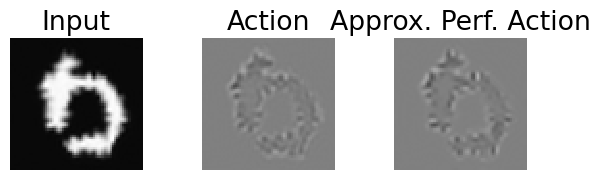

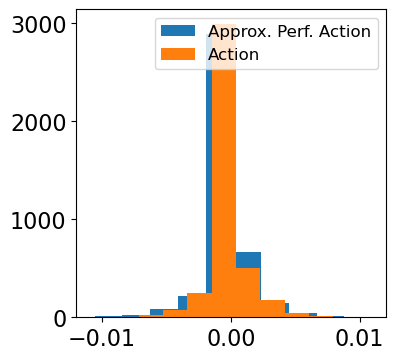

Pearson Correlation Coefficient: 0.7648968171399313


In [10]:
action, analyt, coef = rollout_and_compute_mde_term(env, num_steps=30, do_plot=True)

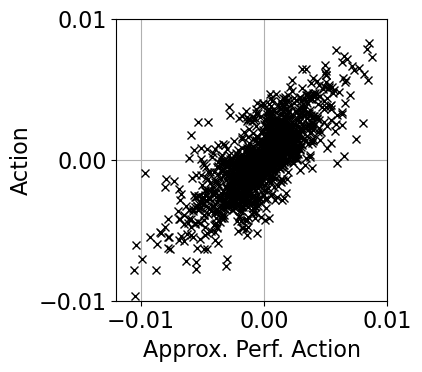

In [12]:
plt.figure(figsize=(4.5, 4))
plt.plot(analyt.flatten(), action.flatten(),  'x', color="black")
#plt.plot(np.linspace(analyt.min(), analyt.max()), np.linspace(analyt.min(), analyt.max()))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlabel("Approx. Perf. Action")
plt.ylabel(r"Action")
plt.ylim(bottom=-0.01, top=0.01)
plt.xlim(left=-0.012, right=0.01)
plt.yticks(np.linspace(-0.01, 0.01, num=3))
plt.xticks(np.linspace(-0.01, 0.01, num=3))
plt.grid(True)
plt.tight_layout()

os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)
plt.savefig(FIG_PATH + f'action_cluster.pdf')

In [19]:
# run NUM_SAMPLES simulations and calculate the pearson correlation coefficient for each one
NUM_SAMPLES = 5
analyt_energs = []
act_energs = []
coefs = np.zeros(NUM_SAMPLES)
for i in tqdm(range(NUM_SAMPLES)):
    act_mean, analyt, coef = rollout_and_compute_mde_term(env, 30, False)
    coefs[i] = coef

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.82s/it]


In [20]:
print(f"Mean pixel wise correlation between the numerically approximated MDE term and the action of the agent:")
print(f"{coefs.mean():.2f} +- {coefs.std():.2f}")

Mean pixel wise correlation between the numerically approximated MDE term and the action of the agent:
0.80 +- 0.05
